In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import myUtils as ut
import math
import numpy as np
import pandas as pd
import random
import seaborn as sb

from lazypredict.supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

from PyBioMed.Pyprotein import CalculateAAComposition, CalculateDipeptideComposition, CalculateCTD, GetAPseudoAAC

import tensorflow as tf

In [2]:
ut.import_data()

In [3]:
sequences_ne = ut.parse_sequences("nonAMP_sequence\\nonAMP_sequence.fasta")
sequences_po = ut.parse_sequences("AMP_sequence\\AMP_sequence.fasta")

random.Random(42).shuffle(sequences_ne)
random.Random(42).shuffle(sequences_po)

print("Count positive AMP:", len(sequences_po))
print("Count negative AMP:", len(sequences_ne))

Count positive AMP: 3268
Count negative AMP: 166791


In [91]:
train_po = sequences_po[:-500]
train_ne = sequences_ne[:len(train_po)]

In [74]:
train_data = ut.prep_data(train_po,train_ne, [CalculateAAComposition, CalculateCTD], verbose=True)

Extraced 168 features from 5536 sequences


In [211]:
train_X = train_data.drop('activity', axis=1)
train_Y = train_data['activity'].copy()

selected_features = ut.select_features(train_X)
train_X = ut.filter_features(train_X, selected_features)

In [217]:
training_features_mask = pd.DataFrame(selected_features, columns=['mask'])
training_features_mask.to_csv("Models\DNN_input_features_mask.csv")

In [181]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(train_X.columns),)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=(1e-4)),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

X = train_X
Y = train_Y
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=500, shuffle=True)

Epoch 1/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5799 - loss: 20.1984 - val_accuracy: 0.7912 - val_loss: 14.6276
Epoch 2/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7402 - loss: 14.6777 - val_accuracy: 0.8671 - val_loss: 12.6956
Epoch 3/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7868 - loss: 12.8794 - val_accuracy: 0.8786 - val_loss: 11.5200
Epoch 4/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8226 - loss: 11.5839 - val_accuracy: 0.8844 - val_loss: 10.6183
Epoch 5/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8203 - loss: 10.6990 - val_accuracy: 0.8931 - val_loss: 9.8672
Epoch 6/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8314 - loss: 9.8886 - val_accuracy: 0.8895 - val_loss: 9.2236
Epoch 7/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8231 - loss: 9.2629 - val_accuracy: 0.8938 - val_loss: 8.6359
Epoch 8/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8187 - loss: 8.6714 -

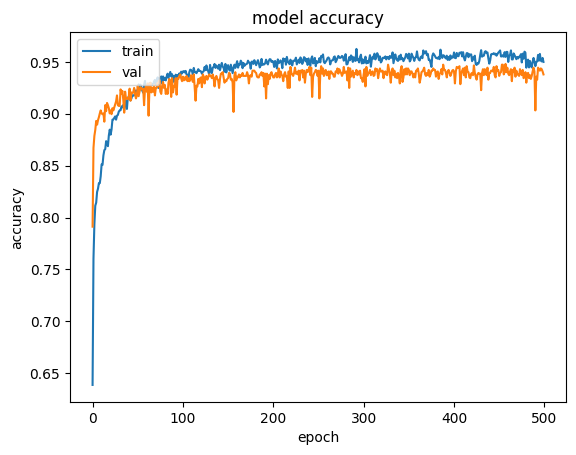

In [182]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

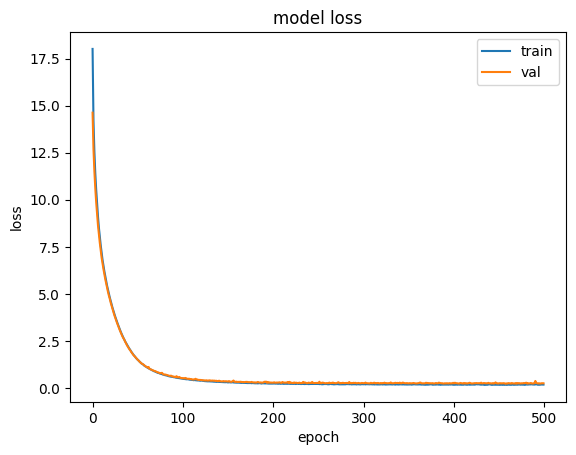

In [183]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [184]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('Test accuracy:', test_acc)

44/44 - 0s - 2ms/step - accuracy: 0.9379 - loss: 0.2496
Test accuracy: 0.9378612637519836


In [185]:
val_po = sequences_po[-500:]
val_ne = sequences_ne[-1000:]

val_data = ut.prep_data(val_po,val_ne, [CalculateAAComposition, CalculateCTD], verbose=True)

val_X = val_data.drop('activity', axis=1)
val_Y = val_data['activity'].copy()

val_X = ut.filter_features(val_X, selected_features)

Extraced 168 features from 1500 sequences


In [186]:
predictions = model.predict(val_X)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [187]:
pred_probability = model.predict_on_batch(val_X)
pred_classes = []
threshold = 0.5
for i in range(len(val_X)):
    if pred_probability[i][0] > threshold:
        res = 1
    else: res = 0
    pred_classes.append([res,val_Y.values[i]])

In [188]:
TP = 0
FP = 0
TN = 0
FN = 0
for pred, res in pred_classes:
    if pred == 1:
        if res == 1:
            TP += 1
        else:
            FP += 1
    
    if pred == 0:
        if res == 0:
            TN += 1
        else:
            FN += 1

confusion_matrix = [[TP,FP],[FN,TP]]

print('TP:', TP)
print('FP:', FP)
print('TN:', TN)
print('FN:', FN)

TP: 478
FP: 48
TN: 952
FN: 22


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Actual')]

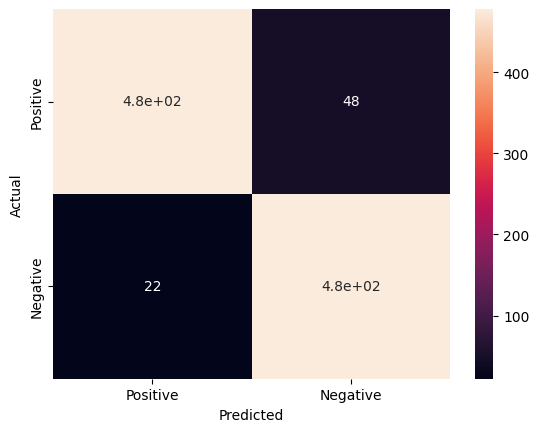

In [189]:
ax = sb.heatmap(confusion_matrix, annot=True, xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
ax.set(xlabel="Predicted", ylabel="Actual")

In [ ]:
def matthews_cor(conf_mat):
    n11 = conf_mat[0][0]/100
    n10 = conf_mat[0][1]/100
    n01 = conf_mat[1][0]/100
    n00 = conf_mat[1][1]/100
    return (n11*n00 - n10*n01) / (np.sqrt((n11+n10)*(n01+n00)*(n10+n00)*(n11+n01)))

round(matthews_cor(confusion_matrix),3)

0.834

In [ ]:
def predict_amp_activity(sequence):
    seq_data = ut.prep_data([sequence],[], [CalculateAAComposition, CalculateCTD])
    seq_data = seq_data.drop('activity', axis=1)
    seq_data = ut.filter_features(seq_data, selected_features)
    prediction = model.predict(seq_data)
    pred_p = prediction[0]
    print(f"{pred_p}% chance of antimicrobial activity")
    
def predict_amp_activity_batch(sequence):
    seq_data = ut.prep_data(sequence,[], [CalculateAAComposition, CalculateCTD])
    seq_data = seq_data.drop('activity', axis=1)
    seq_data = ut.filter_features(seq_data, selected_features)
    prediction = model.predict_on_batch(seq_data)
    return prediction[:]
        

predict_amp_activity(sequences_po[0])
predict_amp_activity(sequences_ne[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[0.3624401]% chance of antimicrobial activity


In [128]:
#model.save('Models\DNN.keras')

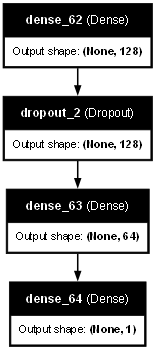

In [167]:
model_DNN = tf.keras.models.load_model('Models\DNN.keras')


In [193]:
pred_1 = model_DNN.predict(val_X)
pred_2 = model.predict(val_X)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
